<a href="https://colab.research.google.com/github/norannali/Feature-Engineering-vs-Raw-Pixels-A-Deep-Dive-into-MNIST-Classification/blob/main/Neural_Network_Classification_of_MNIST_Using_Centroid_Based_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout,BatchNormalization
from keras.optimizers import Adam ,RMSprop
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from scipy.stats import kurtosis
from tensorflow.keras import regularizers

In [ ]:
# import dataset
from keras.datasets import mnist

In [ ]:
# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))
# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels: ", dict(zip(unique, counts)))

Train labels:  {np.uint8(0): np.int64(5923), np.uint8(1): np.int64(6742), np.uint8(2): np.int64(5958), np.uint8(3): np.int64(6131), np.uint8(4): np.int64(5842), np.uint8(5): np.int64(5421), np.uint8(6): np.int64(5918), np.uint8(7): np.int64(6265), np.uint8(8): np.int64(5851), np.uint8(9): np.int64(5949)}
Test labels:  {np.uint8(0): np.int64(980), np.uint8(1): np.int64(1135), np.uint8(2): np.int64(1032), np.uint8(3): np.int64(1010), np.uint8(4): np.int64(982), np.uint8(5): np.int64(892), np.uint8(6): np.int64(958), np.uint8(7): np.int64(1028), np.uint8(8): np.int64(974), np.uint8(9): np.int64(1009)}


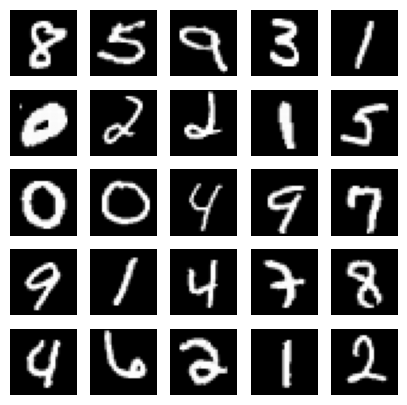

In [ ]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [ ]:
def extract_feature(image):
    # Normalize to [0,1]
    image = image / 255.0

    h, w = image.shape
    y_indices, x_indices = np.indices((h, w))

    # Centroid
    total_intensity = np.sum(image) + 1e-10
    x_centroid = np.sum(x_indices * image) / total_intensity
    y_centroid = np.sum(y_indices * image) / total_intensity

    # Distributions
    horizontal_sums = np.sum(image, axis=1)  # 28
    vertical_sums   = np.sum(image, axis=0)  # 28

    # Statistics
    mean_intensity = np.mean(image)
    variance_intensity = np.var(image)
    std_dev = np.std(image) + 1e-10
    skewness_intensity = np.mean((image - mean_intensity) ** 3) / (std_dev ** 3)
    kurtosis_intensity = kurtosis(image.reshape(-1))

    # Sparsity
    sparsity = np.count_nonzero(image) / image.size

    # Symmetry
    # Vertical Symmetry
    left_half = image[:, :14]
    right_half = np.fliplr(image[:, 14:])
    vertical_symmetry = np.mean(np.abs(left_half - right_half))

    #Horizontal Symmetry
    top_half = image[:14, :]
    bottom_half = np.flipud(image[14:, :])
    horizontal_symmetry = np.mean(np.abs(top_half - bottom_half))

    # Final feature vector
    feature_vector = np.concatenate([
        [x_centroid, y_centroid],      # 2
        horizontal_sums,               # 28
        vertical_sums,                 # 28
        [mean_intensity, variance_intensity, skewness_intensity, kurtosis_intensity, sparsity,
         vertical_symmetry, horizontal_symmetry]  # 7
    ])

    return feature_vector


In [ ]:
x_train_features = np.array([extract_feature(img) for img in x_train])
x_test_features  = np.array([extract_feature(img) for img in x_test])

In [ ]:
print("Train feature shape:", x_train_features.shape)
print("Test feature shape:", x_test_features.shape)

Train feature shape: (60000, 65)
Test feature shape: (10000, 65)


In [ ]:
#  Normalize feature values
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_features)
x_test_scaled  = scaler.transform(x_test_features)

In [ ]:
#  One-hot encode labels (0–9)
y_train_oh = to_categorical(y_train, num_classes=10)
y_test_oh  = to_categorical(y_test, num_classes=10)

In [ ]:
print("X_train_scaled shape:", x_train_scaled.shape)
print("y_train_oh shape:", y_train_oh.shape)

X_train_scaled shape: (60000, 65)
y_train_oh shape: (60000, 10)


In [ ]:
model = Sequential([
    Dense(256, input_shape=(x_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,250 (243.16 KB)

 Trainable params: 61,354 (239.66 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    x_train_scaled, y_train_oh,
    validation_data=(x_test_scaled, y_test_oh),
    epochs=20,
    batch_size=128,
    verbose=1
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6404 - loss: 1.2900 - val_accuracy: 0.8795 - val_loss: 0.5001
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8537 - loss: 0.5821 - val_accuracy: 0.9026 - val_loss: 0.4054
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8753 - loss: 0.4808 - val_accuracy: 0.9132 - val_loss: 0.3486
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8851 - loss: 0.4247 - val_accuracy: 0.9209 - val_loss: 0.3045
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8957 - loss: 0.3792 - val_accuracy: 0.9190 - val_loss: 0.3004
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8977 - loss: 0.3643 - val_accuracy: 0.9259 - val_loss: 0.2772
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9035 - loss: 0.3407 - val_accuracy: 0.9261 - val_loss: 0.2636
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9082 - loss: 0.3289 - val_accuracy: 0.

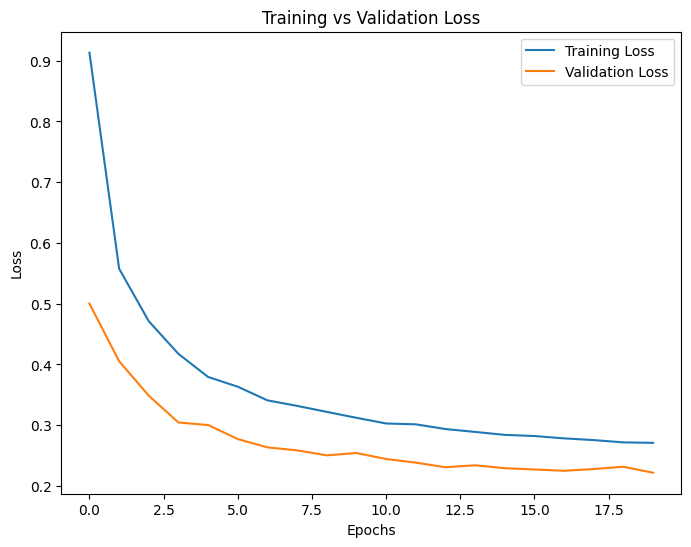

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

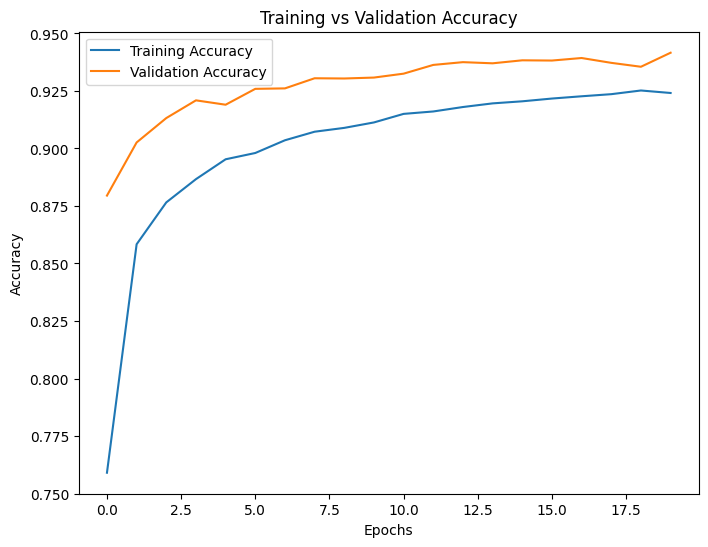

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(x_test_scaled, y_test_oh, verbose=0)
print(f"Test Accuracy (engineered features): {test_acc:.4f}")
print(f"Test Loss (engineered features): {test_loss:.4f}")

Test Accuracy (engineered features): 0.9416
Test Loss (engineered features): 0.2219


Build Baseline Model (Raw Pixels)

In [ ]:
x_train_flat = x_train.reshape(len(x_train), -1) / 255.0
x_test_flat  = x_test.reshape(len(x_test), -1) / 255.0

In [ ]:
print("X_train_flat shape:", x_train_flat.shape)
print("X_test_flat shape:", x_test_flat.shape)

X_train_flat shape: (60000, 784)
X_test_flat shape: (10000, 784)


In [ ]:
baseline_model = Sequential([
    Dense(128, input_shape=(x_train_flat.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
baseline_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,914 (437.16 KB)

 Trainable params: 111,530 (435.66 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
history_baseline = baseline_model.fit(
    x_train_flat, y_train_oh,
    validation_data=(x_test_flat, y_test_oh),
    epochs=20,
    batch_size=128,
    verbose=1
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7276 - loss: 0.8849 - val_accuracy: 0.9460 - val_loss: 0.1703
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9292 - loss: 0.2390 - val_accuracy: 0.9592 - val_loss: 0.1377
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9443 - loss: 0.1846 - val_accuracy: 0.9669 - val_loss: 0.1089
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9540 - loss: 0.1568 - val_accuracy: 0.9683 - val_loss: 0.1039
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9597 - loss: 0.1362 - val_accuracy: 0.9701 - val_loss: 0.1007
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9616 - loss: 0.1258 - val_accuracy: 0.9727 - val_loss: 0.0891
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9647 - loss: 0.1141 - val_accuracy: 0.9723 - val_loss: 0.0957
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9689 - loss: 0.0996 - val_accuracy: 0.

In [ ]:
test_loss_baseline, test_acc_baseline = baseline_model.evaluate(x_test_flat, y_test_oh, verbose=0)
print(f"Baseline Model - Test Accuracy: {test_acc_baseline:.4f}")
print(f"Baseline Model - Test Loss: {test_loss_baseline:.4f}")

Baseline Model - Test Accuracy: 0.9791
Baseline Model - Test Loss: 0.0725


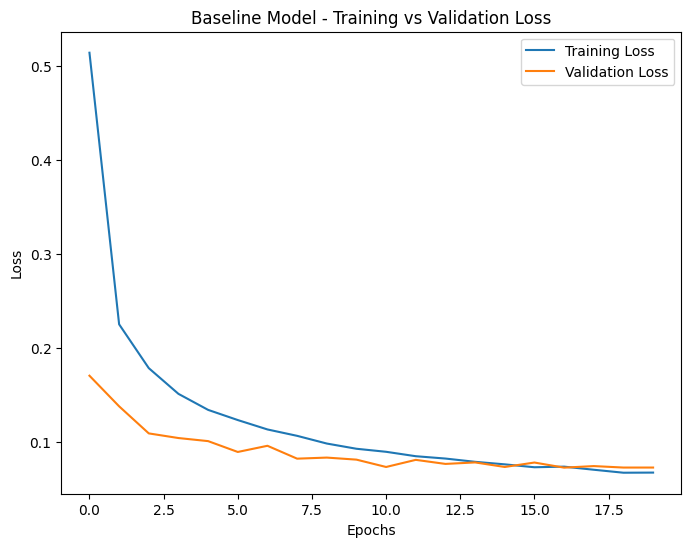

In [ ]:
# Loss
plt.figure(figsize=(8,6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.title('Baseline Model - Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

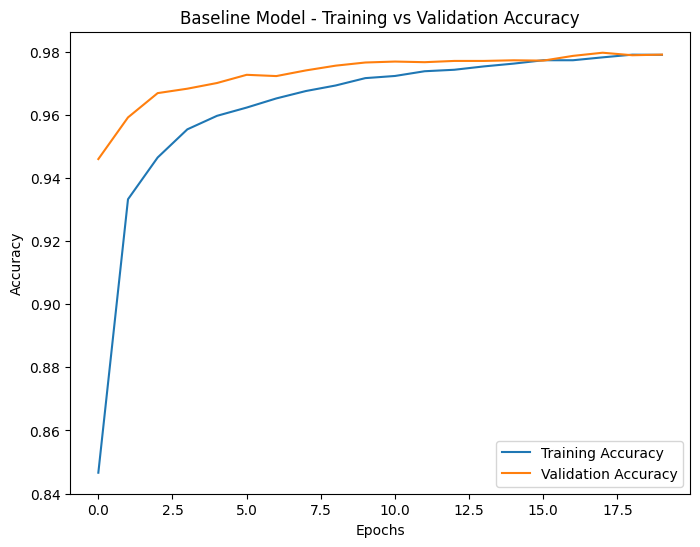

In [ ]:
# Accuracy
plt.figure(figsize=(8,6))
plt.plot(history_baseline.history['accuracy'], label='Training Accuracy')
plt.plot(history_baseline.history['val_accuracy'], label='Validation Accuracy')
plt.title('Baseline Model - Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
print("Engineered Features Accuracy:", test_acc)
print("Raw Pixels Baseline Accuracy:", test_acc_baseline)

Engineered Features Accuracy: 0.9416000247001648
Raw Pixels Baseline Accuracy: 0.9790999889373779


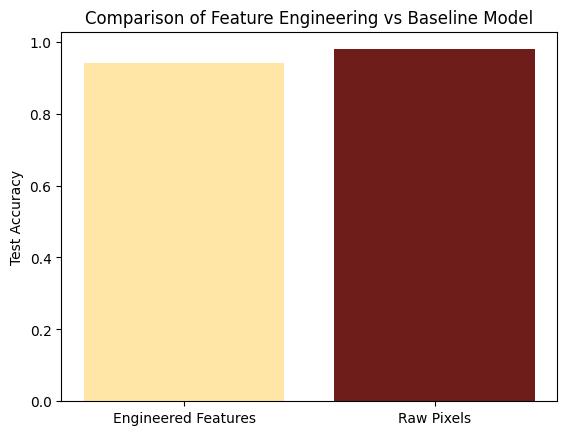

In [ ]:
plt.bar(['Engineered Features', 'Raw Pixels'], [test_acc, test_acc_baseline], color=['#ffe6a7','#6f1d1b'])
plt.ylabel("Test Accuracy")
plt.title("Comparison of Feature Engineering vs Baseline Model")
plt.show()

In [ ]:
# Discussion & Analysis
print("ANALYSIS & DISCUSSION")
print("="*50)
print(f"Engineered Features Accuracy: {test_acc:.4f}")
print(f"Raw Pixels Baseline Accuracy: {test_acc_baseline:.4f}")
print(f"Performance Difference: {abs(test_acc - test_acc_baseline):.4f}")

if test_acc > test_acc_baseline:
    print(" Feature engineering improved performance!")
else:
    print(" Raw pixels performed better than engineered features")

print("\nReflection:")
print("- Centroid features capture spatial distribution of digits")
print("- Statistical features provide intensity characteristics")
print("- Combining both approaches might yield better results")

ANALYSIS & DISCUSSION
Engineered Features Accuracy: 0.9416
Raw Pixels Baseline Accuracy: 0.9791
Performance Difference: 0.0375
 Raw pixels performed better than engineered features

Reflection:
- Centroid features capture spatial distribution of digits
- Statistical features provide intensity characteristics
- Combining both approaches might yield better results


In [ ]:
# Combine engineered features with normalized raw pixels
x_train_combined = np.concatenate([x_train_scaled, x_train_flat], axis=1)
x_test_combined = np.concatenate([x_test_scaled, x_test_flat], axis=1)

In [ ]:
print(f"Engineered features shape: {x_train_scaled.shape}")
print(f"Raw pixels shape: {x_train_flat.shape}")
print(f"Combined features shape: {x_train_combined.shape}")
print(f"Total features: {x_train_combined.shape[1]} (61 engineered + 784 raw pixels)")

Engineered features shape: (60000, 65)
Raw pixels shape: (60000, 784)
Combined features shape: (60000, 849)
Total features: 849 (61 engineered + 784 raw pixels)


In [ ]:
combined_model = Sequential([
    Dense(256, input_shape=(x_train_combined.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [ ]:
combined_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
combined_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 256)            │       217,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 262,954 (1.00 MB)

 Trainable params: 262,058 (1023.66 KB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# Train the combined model
history_combined = combined_model.fit(
    x_train_combined, y_train_oh,
    validation_data=(x_test_combined, y_test_oh),
    epochs=20,
    batch_size=128,
    verbose=1
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7498 - loss: 0.8075 - val_accuracy: 0.9546 - val_loss: 0.1472
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9430 - loss: 0.1951 - val_accuracy: 0.9674 - val_loss: 0.1117
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9521 - loss: 0.1538 - val_accuracy: 0.9736 - val_loss: 0.0923
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9624 - loss: 0.1248 - val_accuracy: 0.9755 - val_loss: 0.0805
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9652 - loss: 0.1145 - val_accuracy: 0.9764 - val_loss: 0.0779
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9695 - loss: 0.1004 - val_accuracy: 0.9773 - val_loss: 0.0798
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9723 - loss: 0.0924 - val_accuracy: 0.9791 - val_loss: 0.0716
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9760 - loss: 0.0830 - val_accuracy: 0.

In [ ]:
# Evaluate combined model
test_loss_combined, test_acc_combined = combined_model.evaluate(x_test_combined, y_test_oh, verbose=0)

In [ ]:
print(f"Test Accuracy: {test_acc_combined:.4f}")
print(f"Test Loss: {test_loss_combined:.4f}")

Test Accuracy: 0.9838
Test Loss: 0.0594


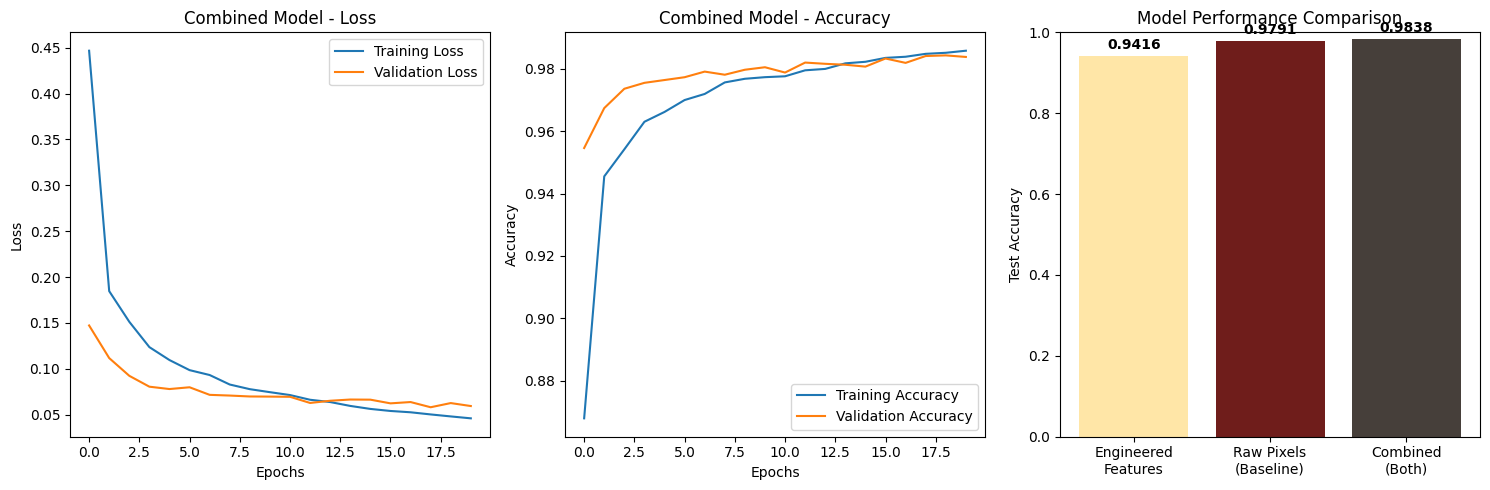

In [ ]:
# Plot training history for combined model
plt.figure(figsize=(15, 5))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(history_combined.history['loss'], label='Training Loss')
plt.plot(history_combined.history['val_loss'], label='Validation Loss')
plt.title('Combined Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(history_combined.history['accuracy'], label='Training Accuracy')
plt.plot(history_combined.history['val_accuracy'], label='Validation Accuracy')
plt.title('Combined Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Comparison bar chart
plt.subplot(1, 3, 3)
models = ['Engineered\nFeatures', 'Raw Pixels\n(Baseline)', 'Combined\n(Both)']
accuracies = [test_acc, test_acc_baseline, test_acc_combined]
colors = ['#ffe6a7', '#6f1d1b', '#463f3a']

bars = plt.bar(models, accuracies, color=colors)
plt.ylabel("Test Accuracy")
plt.title("Model Performance Comparison")
plt.ylim(0, 1)
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
(X_train,_),(X_test,_) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_train,X_test=X_train.reshape(-1,28*28),X_test.reshape(-1,28*28)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers,models

#encoder
encoder=models.Sequential([
    layers.InputLayer(input_shape=(784,)),
    layers.Dense(128,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(32,activation='relu'),#latent space
])

#decoder
decoder=models.Sequential([
    layers.InputLayer(input_shape=(32,)),
    layers.Dense(64,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(784,activation='sigmoid')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
autoencoder=models.Sequential([encoder,decoder])

In [ ]:
autoencoder.compile(optimizer='adam',loss='mse')

In [ ]:
autoencoder.fit(X_train,X_train,epochs=20,batch_size=256,validation_data=(X_test,X_test))

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0953 - val_loss: 0.0369
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0333 - val_loss: 0.0243
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0234 - val_loss: 0.0205
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0205 - val_loss: 0.0188
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0190 - val_loss: 0.0178
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0177 - val_loss: 0.0169
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0165 - val_loss: 0.0152
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0154 - val_loss: 0.0148
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0139 - val_loss: 0.0131
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0134 - val_loss: 0.0125
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


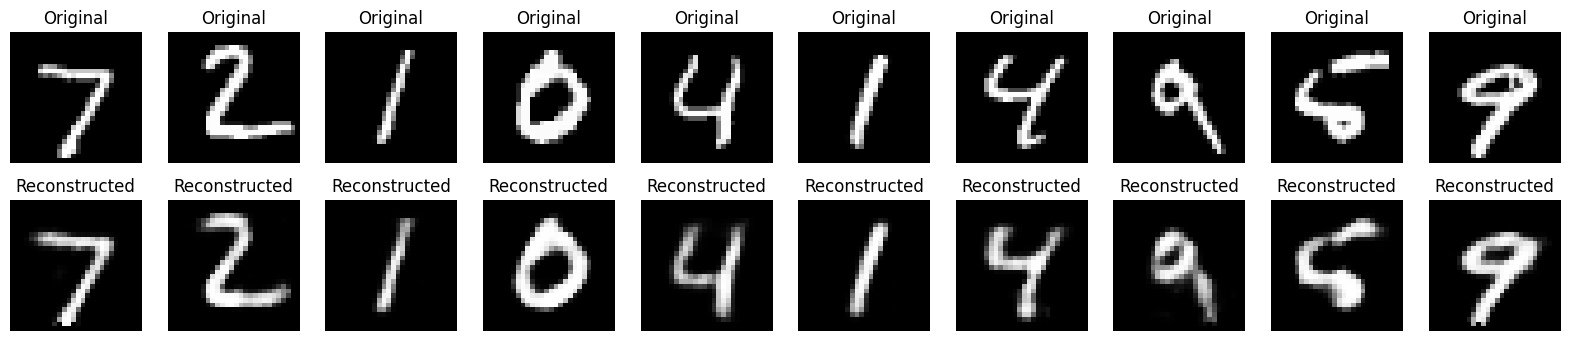

In [ ]:
n = 10
decoded_imgs = autoencoder.predict(X_test[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    # original img
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    # reconstruction img
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


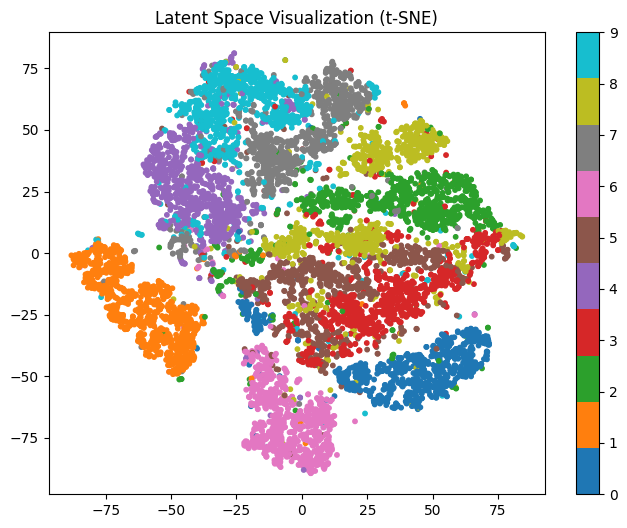

In [59]:
from sklearn.manifold import TSNE

# Extract the latent space representations from the encoder
latent_representations = encoder.predict(X_test)

# Reduce the latent space from 32D → 2D using t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_representations)

plt.figure(figsize=(8, 6))

# Plot the 2D t-SNE embedding
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test[:len(latent_2d)], cmap='tab10', s=10)

plt.colorbar()
plt.title("Latent Space Visualization (t-SNE)")
plt.show()